In [1]:
import pyredner
import torch
import linAlgHelper
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.spatial import ConvexHull, HalfspaceIntersection
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import numpy as np
import trimesh as tm
from scipy.spatial import ConvexHull
from neuralVolumeHelper import randCam, matrixLookat, createInputVector_planeHitModel,HiddenPrints, SIREN, getView, circular2sinCosC,bound2Mesh, compare2CenteredModels, bound2Pointcloud, meshIt, modelCenterCorrection, getPredictionPoints,compare2CenteredModels, bound2bounds, meshBoundsTM, mesh2pointcloud, array2Pointcloud

/home/jhm/miniconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/jhm/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Scene construction, time: 0.61065 s
Forward pass, time: 0.08576 s


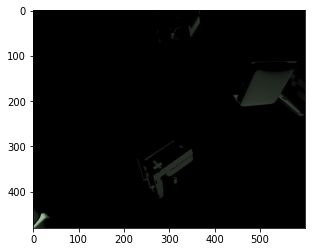

In [2]:
teapot = pyredner.load_obj('chair.obj', return_objects=True)



objects = []

for i in range(8):
    # Obtain the teapot vertices we want to apply the transformation on.
    objectT = pyredner.load_obj('chair.obj', return_objects=True)[0]
    verts = objectT.vertices.clone()/10.
    # Compute the center of the teapot
    center = torch.mean(verts)
    # Get the rotation matrix from Euler angles
    rotation_matrix = pyredner.gen_rotate_matrix(torch.rand(3)*np.pi*2-np.pi).cuda()
    # Shift the vertices to the center, apply rotation matrix,
    # shift back to the original space, then apply the translation.
    objectT.vertices = (verts - center) @ torch.t(rotation_matrix) * (torch.rand(1).cuda()+0.1) + 300*(torch.rand(1,3).cuda()-0.5)
    # Assemble the 3D scene.
    objects.append(objectT)

camera = randCam(cubesize=1000)
scene = pyredner.Scene(camera = camera, objects = objects)
light = pyredner.PointLight(position = (camera.position + torch.tensor((0.0, 0.0, 100.0))).to(pyredner.get_device()),
                                                intensity = torch.tensor((20000.0, 30000.0, 20000.0), device = pyredner.get_device()))
img = pyredner.render_deferred(scene = scene, lights = [light])
from matplotlib.pyplot import imshow
%matplotlib inline
# Gamma correction to convert the image from linear space to sRGB
imshow(torch.pow(img, 1.0/2.2).cpu())

In [6]:
images = []
points = []
camPositions = []

for i in range(3000):
    with torch.no_grad():
            camera = randCam(cubesize=1000)
            scene = pyredner.Scene(camera = camera, objects = objects)
            light = pyredner.PointLight(position = (camera.position + torch.tensor((0.0, 0.0, 100.0))).to(pyredner.get_device()),
                                                            intensity = torch.tensor((20000.0, 30000.0, 20000.0), device = pyredner.get_device()))
            img = pyredner.render_deferred(scene = scene, lights = [light])
            rgb = torch.pow(img, 1.0/2.2).cpu()
            img = pyredner.render_deferred(scene = scene, lights = [light])
            img = pyredner.render_g_buffer(scene = scene, channels = [pyredner.channels.position,
                                                                    pyredner.channels.shading_normal,
                                                                    pyredner.channels.diffuse_reflectance])
            pos = img[:, :, :3]/100
            mask = pos.abs().sum(dim=2) > 0
            if mask.sum() == 0:
                continue
            images.append(rgb)
            try:
                points.append((pos[mask].cpu()[np.random.choice(torch.arange(mask.sum()),min(30000,mask.sum()))]).type(torch.float16))
                camPositions.append(camera.position.clone())
            except:
                del images[-1]
    if i%100 == 0:
        print("rendered ",i)

Scene construction, time: 0.01387 s
Forward pass, time: 0.06670 s
Scene construction, time: 0.01438 s
Forward pass, time: 0.06261 s
Scene construction, time: 0.01231 s
Forward pass, time: 0.02261 s
rendered  0
Scene construction, time: 0.01247 s
Forward pass, time: 0.06462 s
Scene construction, time: 0.01080 s
Forward pass, time: 0.06094 s
Scene construction, time: 0.01067 s
Forward pass, time: 0.01969 s
Scene construction, time: 0.01036 s
Forward pass, time: 0.05701 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.05602 s
Scene construction, time: 0.01076 s
Forward pass, time: 0.01960 s
Scene construction, time: 0.01057 s
Forward pass, time: 0.05971 s
Scene construction, time: 0.01075 s
Forward pass, time: 0.05905 s
Scene construction, time: 0.02699 s
Forward pass, time: 0.02244 s
Scene construction, time: 0.01068 s
Forward pass, time: 0.05138 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.05249 s
Scene construction, time: 0.01088 s
Forward pass, time: 0.01835 

Scene construction, time: 0.01103 s
Forward pass, time: 0.06014 s
Scene construction, time: 0.01070 s
Forward pass, time: 0.01881 s
Scene construction, time: 0.01146 s
Forward pass, time: 0.06042 s
Scene construction, time: 0.01080 s
Forward pass, time: 0.06114 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.01970 s
Scene construction, time: 0.01123 s
Forward pass, time: 0.06034 s
Scene construction, time: 0.01066 s
Forward pass, time: 0.05820 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.01691 s
Scene construction, time: 0.01110 s
Forward pass, time: 0.05934 s
Scene construction, time: 0.01086 s
Forward pass, time: 0.06011 s
Scene construction, time: 0.01058 s
Forward pass, time: 0.01735 s
Scene construction, time: 0.01059 s
Forward pass, time: 0.05420 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.05375 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.01866 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.06687 s
Scene cons

Scene construction, time: 0.01162 s
Forward pass, time: 0.01807 s
Scene construction, time: 0.01425 s
Forward pass, time: 0.05987 s
Scene construction, time: 0.01083 s
Forward pass, time: 0.06352 s
Scene construction, time: 0.01186 s
Forward pass, time: 0.02481 s
Scene construction, time: 0.01337 s
Forward pass, time: 0.05795 s
Scene construction, time: 0.01137 s
Forward pass, time: 0.06129 s
Scene construction, time: 0.01110 s
Forward pass, time: 0.01811 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.05789 s
Scene construction, time: 0.01049 s
Forward pass, time: 0.05549 s
Scene construction, time: 0.01066 s
Forward pass, time: 0.01943 s
Scene construction, time: 0.01056 s
Forward pass, time: 0.04691 s
Scene construction, time: 0.01093 s
Forward pass, time: 0.04728 s
Scene construction, time: 0.01048 s
Forward pass, time: 0.01338 s
Scene construction, time: 0.01057 s
Forward pass, time: 0.05813 s
Scene construction, time: 0.01061 s
Forward pass, time: 0.06015 s
Scene cons

Scene construction, time: 0.01110 s
Forward pass, time: 0.05920 s
Scene construction, time: 0.01051 s
Forward pass, time: 0.06039 s
Scene construction, time: 0.01051 s
Forward pass, time: 0.01914 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.06120 s
Scene construction, time: 0.01122 s
Forward pass, time: 0.05887 s
Scene construction, time: 0.01051 s
Forward pass, time: 0.01896 s
Scene construction, time: 0.01045 s
Forward pass, time: 0.05726 s
Scene construction, time: 0.01062 s
Forward pass, time: 0.06073 s
Scene construction, time: 0.01158 s
Forward pass, time: 0.01871 s
Scene construction, time: 0.01183 s
Forward pass, time: 0.04946 s
Scene construction, time: 0.01050 s
Forward pass, time: 0.05116 s
Scene construction, time: 0.01053 s
Forward pass, time: 0.01825 s
Scene construction, time: 0.01274 s
Forward pass, time: 0.05256 s
Scene construction, time: 0.01059 s
Forward pass, time: 0.05202 s
Scene construction, time: 0.01050 s
Forward pass, time: 0.01750 s
Scene cons

Scene construction, time: 0.01195 s
Forward pass, time: 0.06462 s
Scene construction, time: 0.01060 s
Forward pass, time: 0.02117 s
Scene construction, time: 0.01088 s
Forward pass, time: 0.05820 s
Scene construction, time: 0.01186 s
Forward pass, time: 0.05831 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.01822 s
Scene construction, time: 0.01042 s
Forward pass, time: 0.05915 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.05904 s
Scene construction, time: 0.01075 s
Forward pass, time: 0.01933 s
Scene construction, time: 0.01229 s
Forward pass, time: 0.06711 s
Scene construction, time: 0.01048 s
Forward pass, time: 0.06746 s
Scene construction, time: 0.01055 s
Forward pass, time: 0.01818 s
Scene construction, time: 0.01144 s
Forward pass, time: 0.05613 s
Scene construction, time: 0.01056 s
Forward pass, time: 0.05433 s
Scene construction, time: 0.01043 s
Forward pass, time: 0.01945 s
Scene construction, time: 0.01037 s
Forward pass, time: 0.05311 s
Scene cons

Scene construction, time: 0.01275 s
Forward pass, time: 0.01997 s
Scene construction, time: 0.01059 s
Forward pass, time: 0.05098 s
Scene construction, time: 0.01048 s
Forward pass, time: 0.05262 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.01852 s
Scene construction, time: 0.01112 s
Forward pass, time: 0.06353 s
Scene construction, time: 0.01122 s
Forward pass, time: 0.06394 s
Scene construction, time: 0.01074 s
Forward pass, time: 0.02242 s
Scene construction, time: 0.01235 s
Forward pass, time: 0.06416 s
Scene construction, time: 0.01064 s
Forward pass, time: 0.05944 s
Scene construction, time: 0.01079 s
Forward pass, time: 0.02049 s
Scene construction, time: 0.01037 s
Forward pass, time: 0.05415 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.05543 s
Scene construction, time: 0.01046 s
Forward pass, time: 0.01832 s
Scene construction, time: 0.01093 s
Forward pass, time: 0.05744 s
Scene construction, time: 0.01055 s
Forward pass, time: 0.05760 s
Scene cons

Forward pass, time: 0.01702 s
Scene construction, time: 0.01083 s
Forward pass, time: 0.06082 s
Scene construction, time: 0.01054 s
Forward pass, time: 0.06019 s
Scene construction, time: 0.01064 s
Forward pass, time: 0.02012 s
Scene construction, time: 0.01058 s
Forward pass, time: 0.04966 s
Scene construction, time: 0.01090 s
Forward pass, time: 0.05351 s
Scene construction, time: 0.01059 s
Forward pass, time: 0.01727 s
Scene construction, time: 0.01037 s
Forward pass, time: 0.05988 s
Scene construction, time: 0.01061 s
Forward pass, time: 0.05990 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.01867 s
Scene construction, time: 0.01055 s
Forward pass, time: 0.05209 s
Scene construction, time: 0.01060 s
Forward pass, time: 0.05717 s
Scene construction, time: 0.01057 s
Forward pass, time: 0.01834 s
Scene construction, time: 0.01119 s
Forward pass, time: 0.06090 s
Scene construction, time: 0.01087 s
Forward pass, time: 0.06027 s
Scene construction, time: 0.01083 s
Forward pa

Scene construction, time: 0.01125 s
Forward pass, time: 0.05149 s
Scene construction, time: 0.01078 s
Forward pass, time: 0.01876 s
Scene construction, time: 0.01080 s
Forward pass, time: 0.05865 s
Scene construction, time: 0.01076 s
Forward pass, time: 0.05947 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.02039 s
Scene construction, time: 0.01049 s
Forward pass, time: 0.06300 s
Scene construction, time: 0.01046 s
Forward pass, time: 0.05994 s
Scene construction, time: 0.01075 s
Forward pass, time: 0.02119 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.05663 s
Scene construction, time: 0.01094 s
Forward pass, time: 0.06037 s
Scene construction, time: 0.01072 s
Forward pass, time: 0.01916 s
Scene construction, time: 0.01057 s
Forward pass, time: 0.05464 s
Scene construction, time: 0.01076 s
Forward pass, time: 0.05770 s
Scene construction, time: 0.01049 s
Forward pass, time: 0.01959 s
Scene construction, time: 0.01044 s
Forward pass, time: 0.06008 s
Scene cons

Forward pass, time: 0.01693 s
Scene construction, time: 0.01097 s
Forward pass, time: 0.05551 s
Scene construction, time: 0.01079 s
Forward pass, time: 0.05737 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.01883 s
Scene construction, time: 0.01120 s
Forward pass, time: 0.05512 s
Scene construction, time: 0.01131 s
Forward pass, time: 0.06162 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.01996 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.05906 s
Scene construction, time: 0.01084 s
Forward pass, time: 0.05553 s
Scene construction, time: 0.01215 s
Forward pass, time: 0.01892 s
Scene construction, time: 0.01054 s
Forward pass, time: 0.05163 s
Scene construction, time: 0.01050 s
Forward pass, time: 0.05309 s
Scene construction, time: 0.01045 s
Forward pass, time: 0.01952 s
Scene construction, time: 0.01118 s
Forward pass, time: 0.05082 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.05321 s
Scene construction, time: 0.01137 s
Forward pa

Scene construction, time: 0.01065 s
Forward pass, time: 0.05851 s
Scene construction, time: 0.01122 s
Forward pass, time: 0.02099 s
Scene construction, time: 0.01054 s
Forward pass, time: 0.05653 s
Scene construction, time: 0.01067 s
Forward pass, time: 0.05728 s
Scene construction, time: 0.01062 s
Forward pass, time: 0.01993 s
Scene construction, time: 0.01109 s
Forward pass, time: 0.05927 s
Scene construction, time: 0.01122 s
Forward pass, time: 0.06077 s
Scene construction, time: 0.01158 s
Forward pass, time: 0.01845 s
Scene construction, time: 0.01166 s
Forward pass, time: 0.05989 s
Scene construction, time: 0.01207 s
Forward pass, time: 0.06063 s
Scene construction, time: 0.01051 s
Forward pass, time: 0.01924 s
Scene construction, time: 0.01176 s
Forward pass, time: 0.05931 s
Scene construction, time: 0.01082 s
Forward pass, time: 0.05871 s
Scene construction, time: 0.01060 s
Forward pass, time: 0.01997 s
Scene construction, time: 0.01041 s
Forward pass, time: 0.05977 s
Scene cons

Scene construction, time: 0.01208 s
Forward pass, time: 0.06327 s
Scene construction, time: 0.01181 s
Forward pass, time: 0.06188 s
Scene construction, time: 0.01196 s
Forward pass, time: 0.01921 s
Scene construction, time: 0.01333 s
Forward pass, time: 0.06136 s
Scene construction, time: 0.01254 s
Forward pass, time: 0.06674 s
Scene construction, time: 0.01147 s
Forward pass, time: 0.01913 s
Scene construction, time: 0.01349 s
Forward pass, time: 0.05322 s
Scene construction, time: 0.01252 s
Forward pass, time: 0.05520 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.01806 s
Scene construction, time: 0.01136 s
Forward pass, time: 0.05842 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.05791 s
Scene construction, time: 0.01205 s
Forward pass, time: 0.01916 s
Scene construction, time: 0.01240 s
Forward pass, time: 0.05567 s
Scene construction, time: 0.01137 s
Forward pass, time: 0.05855 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.01851 s
Scene cons

Scene construction, time: 0.01213 s
Forward pass, time: 0.06331 s
Scene construction, time: 0.01243 s
Forward pass, time: 0.01808 s
Scene construction, time: 0.01143 s
Forward pass, time: 0.05892 s
Scene construction, time: 0.01135 s
Forward pass, time: 0.06276 s
Scene construction, time: 0.01173 s
Forward pass, time: 0.02049 s
Scene construction, time: 0.01231 s
Forward pass, time: 0.06137 s
Scene construction, time: 0.01199 s
Forward pass, time: 0.06062 s
Scene construction, time: 0.01161 s
Forward pass, time: 0.01870 s
Scene construction, time: 0.01329 s
Forward pass, time: 0.06692 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.06532 s
Scene construction, time: 0.01130 s
Forward pass, time: 0.01948 s
Scene construction, time: 0.01226 s
Forward pass, time: 0.06291 s
Scene construction, time: 0.01205 s
Forward pass, time: 0.07119 s
Scene construction, time: 0.01173 s
Forward pass, time: 0.02374 s
Scene construction, time: 0.01259 s
Forward pass, time: 0.05841 s
Scene cons

Forward pass, time: 0.02278 s
Scene construction, time: 0.01126 s
Forward pass, time: 0.05540 s
Scene construction, time: 0.01171 s
Forward pass, time: 0.05520 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.01873 s
Scene construction, time: 0.01083 s
Forward pass, time: 0.05649 s
Scene construction, time: 0.01256 s
Forward pass, time: 0.05937 s
Scene construction, time: 0.01199 s
Forward pass, time: 0.01640 s
Scene construction, time: 0.01168 s
Forward pass, time: 0.06415 s
Scene construction, time: 0.01223 s
Forward pass, time: 0.05998 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.02183 s
Scene construction, time: 0.01176 s
Forward pass, time: 0.07035 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.06631 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.02333 s
Scene construction, time: 0.01161 s
Forward pass, time: 0.06238 s
Scene construction, time: 0.01185 s
Forward pass, time: 0.07290 s
Scene construction, time: 0.01272 s
Forward pa

Scene construction, time: 0.01200 s
Forward pass, time: 0.05961 s
Scene construction, time: 0.01153 s
Forward pass, time: 0.06138 s
Scene construction, time: 0.01196 s
Forward pass, time: 0.02190 s
Scene construction, time: 0.01184 s
Forward pass, time: 0.04991 s
Scene construction, time: 0.01116 s
Forward pass, time: 0.05436 s
Scene construction, time: 0.01189 s
Forward pass, time: 0.01770 s
Scene construction, time: 0.01199 s
Forward pass, time: 0.06077 s
Scene construction, time: 0.01253 s
Forward pass, time: 0.06355 s
Scene construction, time: 0.01180 s
Forward pass, time: 0.02029 s
Scene construction, time: 0.01173 s
Forward pass, time: 0.05806 s
Scene construction, time: 0.01136 s
Forward pass, time: 0.05737 s
Scene construction, time: 0.01173 s
Forward pass, time: 0.01863 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.06279 s
Scene construction, time: 0.01072 s
Forward pass, time: 0.06310 s
Scene construction, time: 0.01167 s
Forward pass, time: 0.01993 s
Scene cons

Scene construction, time: 0.01100 s
Forward pass, time: 0.06908 s
Scene construction, time: 0.01135 s
Forward pass, time: 0.02032 s
Scene construction, time: 0.01074 s
Forward pass, time: 0.05707 s
Scene construction, time: 0.01116 s
Forward pass, time: 0.05820 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.02169 s
Scene construction, time: 0.01092 s
Forward pass, time: 0.06066 s
Scene construction, time: 0.01075 s
Forward pass, time: 0.05970 s
Scene construction, time: 0.01284 s
Forward pass, time: 0.01997 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.05815 s
Scene construction, time: 0.01117 s
Forward pass, time: 0.05859 s
Scene construction, time: 0.01122 s
Forward pass, time: 0.01984 s
Scene construction, time: 0.01141 s
Forward pass, time: 0.05141 s
Scene construction, time: 0.01189 s
Forward pass, time: 0.05520 s
Scene construction, time: 0.01142 s
Forward pass, time: 0.01805 s
Scene construction, time: 0.01172 s
Forward pass, time: 0.06249 s
Scene cons

Scene construction, time: 0.01176 s
Forward pass, time: 0.06337 s
Scene construction, time: 0.01239 s
Forward pass, time: 0.06120 s
Scene construction, time: 0.01183 s
Forward pass, time: 0.02092 s
Scene construction, time: 0.01136 s
Forward pass, time: 0.06345 s
Scene construction, time: 0.01144 s
Forward pass, time: 0.06168 s
Scene construction, time: 0.01174 s
Forward pass, time: 0.01997 s
Scene construction, time: 0.01188 s
Forward pass, time: 0.05615 s
Scene construction, time: 0.01202 s
Forward pass, time: 0.05719 s
Scene construction, time: 0.01188 s
Forward pass, time: 0.01711 s
Scene construction, time: 0.01166 s
Forward pass, time: 0.06382 s
Scene construction, time: 0.01186 s
Forward pass, time: 0.06239 s
Scene construction, time: 0.01191 s
Forward pass, time: 0.02143 s
Scene construction, time: 0.01074 s
Forward pass, time: 0.06467 s
Scene construction, time: 0.01090 s
Forward pass, time: 0.06774 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.02384 s
Scene cons

Forward pass, time: 0.05924 s
Scene construction, time: 0.01202 s
Forward pass, time: 0.05927 s
Scene construction, time: 0.01175 s
Forward pass, time: 0.02029 s
Scene construction, time: 0.01194 s
Forward pass, time: 0.05655 s
Scene construction, time: 0.01201 s
Forward pass, time: 0.06007 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.02039 s
Scene construction, time: 0.01191 s
Forward pass, time: 0.05530 s
Scene construction, time: 0.01123 s
Forward pass, time: 0.06243 s
Scene construction, time: 0.01130 s
Forward pass, time: 0.02070 s
Scene construction, time: 0.01165 s
Forward pass, time: 0.06302 s
Scene construction, time: 0.01155 s
Forward pass, time: 0.06159 s
Scene construction, time: 0.01143 s
Forward pass, time: 0.02380 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.05561 s
Scene construction, time: 0.01189 s
Forward pass, time: 0.06066 s
Scene construction, time: 0.01122 s
Forward pass, time: 0.02137 s
Scene construction, time: 0.01164 s
Forward pa

Scene construction, time: 0.01248 s
Forward pass, time: 0.05945 s
Scene construction, time: 0.01147 s
Forward pass, time: 0.01989 s
Scene construction, time: 0.01157 s
Forward pass, time: 0.05483 s
Scene construction, time: 0.01080 s
Forward pass, time: 0.05426 s
Scene construction, time: 0.01322 s
Forward pass, time: 0.01957 s
Scene construction, time: 0.01155 s
Forward pass, time: 0.05613 s
Scene construction, time: 0.01142 s
Forward pass, time: 0.05897 s
Scene construction, time: 0.01113 s
Forward pass, time: 0.01939 s
Scene construction, time: 0.01272 s
Forward pass, time: 0.06376 s
Scene construction, time: 0.01308 s
Forward pass, time: 0.06235 s
Scene construction, time: 0.01133 s
Forward pass, time: 0.02193 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.06413 s
Scene construction, time: 0.01092 s
Forward pass, time: 0.06658 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.02073 s
Scene construction, time: 0.01180 s
Forward pass, time: 0.06175 s
Scene cons

Forward pass, time: 0.06422 s
Scene construction, time: 0.01231 s
Forward pass, time: 0.02234 s
Scene construction, time: 0.01204 s
Forward pass, time: 0.06020 s
Scene construction, time: 0.01174 s
Forward pass, time: 0.06717 s
Scene construction, time: 0.01235 s
Forward pass, time: 0.01990 s
Scene construction, time: 0.01158 s
Forward pass, time: 0.06348 s
Scene construction, time: 0.01184 s
Forward pass, time: 0.06222 s
Scene construction, time: 0.01205 s
Forward pass, time: 0.02149 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.05899 s
Scene construction, time: 0.01175 s
Forward pass, time: 0.06007 s
Scene construction, time: 0.01124 s
Forward pass, time: 0.02087 s
Scene construction, time: 0.01211 s
Forward pass, time: 0.05628 s
Scene construction, time: 0.01139 s
Forward pass, time: 0.05758 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.01988 s
Scene construction, time: 0.01119 s
Forward pass, time: 0.06487 s
Scene construction, time: 0.01171 s
Forward pa

Scene construction, time: 0.01118 s
Forward pass, time: 0.06036 s
Scene construction, time: 0.01109 s
Forward pass, time: 0.05902 s
Scene construction, time: 0.01181 s
Forward pass, time: 0.01852 s
Scene construction, time: 0.01133 s
Forward pass, time: 0.07246 s
Scene construction, time: 0.01256 s
Forward pass, time: 0.06430 s
Scene construction, time: 0.01183 s
Forward pass, time: 0.02013 s
Scene construction, time: 0.01304 s
Forward pass, time: 0.06188 s
Scene construction, time: 0.01219 s
Forward pass, time: 0.06387 s
Scene construction, time: 0.01155 s
Forward pass, time: 0.01843 s
rendered  800
Scene construction, time: 0.01300 s
Forward pass, time: 0.05756 s
Scene construction, time: 0.01242 s
Forward pass, time: 0.05976 s
Scene construction, time: 0.01090 s
Forward pass, time: 0.01821 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.05972 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.06014 s
Scene construction, time: 0.01211 s
Forward pass, time: 0.0205

Forward pass, time: 0.06512 s
Scene construction, time: 0.01313 s
Forward pass, time: 0.06651 s
Scene construction, time: 0.01154 s
Forward pass, time: 0.02132 s
Scene construction, time: 0.01112 s
Forward pass, time: 0.06681 s
Scene construction, time: 0.01296 s
Forward pass, time: 0.07051 s
Scene construction, time: 0.01182 s
Forward pass, time: 0.02109 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.05827 s
Scene construction, time: 0.01177 s
Forward pass, time: 0.06302 s
Scene construction, time: 0.01109 s
Forward pass, time: 0.02050 s
Scene construction, time: 0.01247 s
Forward pass, time: 0.05759 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.05897 s
Scene construction, time: 0.01164 s
Forward pass, time: 0.01938 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.06312 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.06867 s
Scene construction, time: 0.01205 s
Forward pass, time: 0.02318 s
Scene construction, time: 0.01119 s
Forward pa

Scene construction, time: 0.01088 s
Forward pass, time: 0.05550 s
Scene construction, time: 0.01429 s
Forward pass, time: 0.05854 s
Scene construction, time: 0.01292 s
Forward pass, time: 0.02290 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.06474 s
Scene construction, time: 0.01151 s
Forward pass, time: 0.06835 s
Scene construction, time: 0.01216 s
Forward pass, time: 0.02390 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.06089 s
Scene construction, time: 0.01146 s
Forward pass, time: 0.06112 s
Scene construction, time: 0.01328 s
Forward pass, time: 0.01949 s
Scene construction, time: 0.01174 s
Forward pass, time: 0.06559 s
Scene construction, time: 0.01234 s
Forward pass, time: 0.06084 s
Scene construction, time: 0.01196 s
Forward pass, time: 0.01964 s
Scene construction, time: 0.01211 s
Forward pass, time: 0.06694 s
Scene construction, time: 0.01126 s
Forward pass, time: 0.06910 s
Scene construction, time: 0.01149 s
Forward pass, time: 0.02063 s
Scene cons

Scene construction, time: 0.01189 s
Forward pass, time: 0.01932 s
Scene construction, time: 0.01254 s
Forward pass, time: 0.05730 s
Scene construction, time: 0.01724 s
Forward pass, time: 0.05827 s
Scene construction, time: 0.01118 s
Forward pass, time: 0.02093 s
Scene construction, time: 0.01279 s
Forward pass, time: 0.05425 s
Scene construction, time: 0.01129 s
Forward pass, time: 0.05685 s
Scene construction, time: 0.01183 s
Forward pass, time: 0.01753 s
Scene construction, time: 0.01222 s
Forward pass, time: 0.06896 s
Scene construction, time: 0.01138 s
Forward pass, time: 0.06424 s
Scene construction, time: 0.01132 s
Forward pass, time: 0.02229 s
Scene construction, time: 0.01145 s
Forward pass, time: 0.05992 s
Scene construction, time: 0.01266 s
Forward pass, time: 0.06021 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.02205 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.05751 s
Scene construction, time: 0.01290 s
Forward pass, time: 0.05689 s
Scene cons

Scene construction, time: 0.01365 s
Forward pass, time: 0.06786 s
Scene construction, time: 0.01276 s
Forward pass, time: 0.02081 s
Scene construction, time: 0.01216 s
Forward pass, time: 0.06592 s
Scene construction, time: 0.01436 s
Forward pass, time: 0.06289 s
Scene construction, time: 0.01251 s
Forward pass, time: 0.02331 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.05762 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.05940 s
Scene construction, time: 0.01226 s
Forward pass, time: 0.01965 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.06325 s
Scene construction, time: 0.01106 s
Forward pass, time: 0.06837 s
Scene construction, time: 0.01404 s
Forward pass, time: 0.02350 s
Scene construction, time: 0.01418 s
Forward pass, time: 0.06163 s
Scene construction, time: 0.01187 s
Forward pass, time: 0.06064 s
Scene construction, time: 0.01154 s
Forward pass, time: 0.02206 s
Scene construction, time: 0.01228 s
Forward pass, time: 0.06377 s
Scene cons

Scene construction, time: 0.01284 s
Forward pass, time: 0.02115 s
Scene construction, time: 0.01178 s
Forward pass, time: 0.06573 s
Scene construction, time: 0.01094 s
Forward pass, time: 0.06708 s
Scene construction, time: 0.01106 s
Forward pass, time: 0.02221 s
Scene construction, time: 0.01233 s
Forward pass, time: 0.06281 s
Scene construction, time: 0.01201 s
Forward pass, time: 0.06445 s
Scene construction, time: 0.01169 s
Forward pass, time: 0.02059 s
Scene construction, time: 0.01143 s
Forward pass, time: 0.06546 s
Scene construction, time: 0.01182 s
Forward pass, time: 0.06142 s
Scene construction, time: 0.01092 s
Forward pass, time: 0.02212 s
Scene construction, time: 0.01236 s
Forward pass, time: 0.06983 s
Scene construction, time: 0.01175 s
Forward pass, time: 0.06752 s
Scene construction, time: 0.01214 s
Forward pass, time: 0.02232 s
Scene construction, time: 0.01259 s
Forward pass, time: 0.06440 s
Scene construction, time: 0.01186 s
Forward pass, time: 0.06405 s
Scene cons

Scene construction, time: 0.01207 s
Forward pass, time: 0.05863 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.06088 s
Scene construction, time: 0.01208 s
Forward pass, time: 0.01926 s
Scene construction, time: 0.01133 s
Forward pass, time: 0.06387 s
Scene construction, time: 0.01204 s
Forward pass, time: 0.06034 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.02265 s
Scene construction, time: 0.01226 s
Forward pass, time: 0.06223 s
Scene construction, time: 0.01355 s
Forward pass, time: 0.06150 s
Scene construction, time: 0.01212 s
Forward pass, time: 0.02004 s
Scene construction, time: 0.01181 s
Forward pass, time: 0.06626 s
Scene construction, time: 0.01274 s
Forward pass, time: 0.06302 s
Scene construction, time: 0.01333 s
Forward pass, time: 0.02323 s
Scene construction, time: 0.01163 s
Forward pass, time: 0.06086 s
Scene construction, time: 0.01344 s
Forward pass, time: 0.06830 s
Scene construction, time: 0.01240 s
Forward pass, time: 0.02311 s
Scene cons

Scene construction, time: 0.01142 s
Forward pass, time: 0.06384 s
Scene construction, time: 0.01078 s
Forward pass, time: 0.02124 s
Scene construction, time: 0.01072 s
Forward pass, time: 0.05015 s
Scene construction, time: 0.01155 s
Forward pass, time: 0.05436 s
Scene construction, time: 0.01080 s
Forward pass, time: 0.01837 s
Scene construction, time: 0.01055 s
Forward pass, time: 0.05560 s
Scene construction, time: 0.01066 s
Forward pass, time: 0.05757 s
Scene construction, time: 0.01063 s
Forward pass, time: 0.01918 s
Scene construction, time: 0.01084 s
Forward pass, time: 0.05280 s
Scene construction, time: 0.01076 s
Forward pass, time: 0.05453 s
Scene construction, time: 0.01062 s
Forward pass, time: 0.01892 s
Scene construction, time: 0.01054 s
Forward pass, time: 0.05813 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.05837 s
Scene construction, time: 0.01071 s
Forward pass, time: 0.01898 s
Scene construction, time: 0.01046 s
Forward pass, time: 0.04997 s
Scene cons

Forward pass, time: 0.05891 s
Scene construction, time: 0.01137 s
Forward pass, time: 0.05259 s
Scene construction, time: 0.01079 s
Forward pass, time: 0.01825 s
Scene construction, time: 0.01048 s
Forward pass, time: 0.06012 s
Scene construction, time: 0.01062 s
Forward pass, time: 0.06015 s
Scene construction, time: 0.01088 s
Forward pass, time: 0.02008 s
Scene construction, time: 0.01052 s
Forward pass, time: 0.06333 s
Scene construction, time: 0.01053 s
Forward pass, time: 0.06431 s
Scene construction, time: 0.01054 s
Forward pass, time: 0.01922 s
Scene construction, time: 0.01113 s
Forward pass, time: 0.06601 s
Scene construction, time: 0.01054 s
Forward pass, time: 0.06500 s
Scene construction, time: 0.01056 s
Forward pass, time: 0.01772 s
Scene construction, time: 0.01120 s
Forward pass, time: 0.05057 s
Scene construction, time: 0.01067 s
Forward pass, time: 0.05370 s
Scene construction, time: 0.01069 s
Forward pass, time: 0.01866 s
Scene construction, time: 0.01050 s
Forward pa

Forward pass, time: 0.01898 s
Scene construction, time: 0.01079 s
Forward pass, time: 0.05683 s
Scene construction, time: 0.01060 s
Forward pass, time: 0.05780 s
Scene construction, time: 0.01052 s
Forward pass, time: 0.01912 s
Scene construction, time: 0.01060 s
Forward pass, time: 0.05858 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.06037 s
Scene construction, time: 0.01050 s
Forward pass, time: 0.02098 s
Scene construction, time: 0.01054 s
Forward pass, time: 0.05864 s
Scene construction, time: 0.01071 s
Forward pass, time: 0.05894 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.01918 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.05293 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.05303 s
Scene construction, time: 0.01076 s
Forward pass, time: 0.01871 s
Scene construction, time: 0.01079 s
Forward pass, time: 0.05932 s
Scene construction, time: 0.01056 s
Forward pass, time: 0.05796 s
Scene construction, time: 0.01059 s
Forward pa

Scene construction, time: 0.01177 s
Forward pass, time: 0.02107 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.05728 s
Scene construction, time: 0.01177 s
Forward pass, time: 0.05799 s
Scene construction, time: 0.01084 s
Forward pass, time: 0.01947 s
Scene construction, time: 0.01220 s
Forward pass, time: 0.05509 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.05507 s
Scene construction, time: 0.01185 s
Forward pass, time: 0.01854 s
Scene construction, time: 0.01094 s
Forward pass, time: 0.05757 s
Scene construction, time: 0.01085 s
Forward pass, time: 0.05466 s
Scene construction, time: 0.01165 s
Forward pass, time: 0.01625 s
Scene construction, time: 0.01065 s
Forward pass, time: 0.05654 s
Scene construction, time: 0.01076 s
Forward pass, time: 0.05681 s
Scene construction, time: 0.01242 s
Forward pass, time: 0.01923 s
Scene construction, time: 0.01093 s
Forward pass, time: 0.06302 s
Scene construction, time: 0.01164 s
Forward pass, time: 0.06485 s
Scene cons

Forward pass, time: 0.06174 s
Scene construction, time: 0.01189 s
Forward pass, time: 0.05760 s
Scene construction, time: 0.01112 s
Forward pass, time: 0.02009 s
Scene construction, time: 0.01086 s
Forward pass, time: 0.05653 s
Scene construction, time: 0.01335 s
Forward pass, time: 0.05852 s
Scene construction, time: 0.01130 s
Forward pass, time: 0.01828 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.05620 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.05427 s
Scene construction, time: 0.01143 s
Forward pass, time: 0.01966 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.05530 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.05411 s
Scene construction, time: 0.01075 s
Forward pass, time: 0.01934 s
Scene construction, time: 0.01156 s
Forward pass, time: 0.06166 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.06108 s
Scene construction, time: 0.01151 s
Forward pass, time: 0.02198 s
Scene construction, time: 0.01115 s
Forward pa

Scene construction, time: 0.01127 s
Forward pass, time: 0.02139 s
Scene construction, time: 0.01125 s
Forward pass, time: 0.05850 s
Scene construction, time: 0.01091 s
Forward pass, time: 0.05874 s
Scene construction, time: 0.01084 s
Forward pass, time: 0.01956 s
Scene construction, time: 0.01116 s
Forward pass, time: 0.06327 s
Scene construction, time: 0.01112 s
Forward pass, time: 0.06249 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.02099 s
Scene construction, time: 0.01126 s
Forward pass, time: 0.06275 s
Scene construction, time: 0.01173 s
Forward pass, time: 0.06083 s
Scene construction, time: 0.01159 s
Forward pass, time: 0.02003 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.05397 s
Scene construction, time: 0.01084 s
Forward pass, time: 0.05530 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.01951 s
Scene construction, time: 0.01205 s
Forward pass, time: 0.06196 s
Scene construction, time: 0.01078 s
Forward pass, time: 0.06070 s
Scene cons

Scene construction, time: 0.01105 s
Forward pass, time: 0.05377 s
Scene construction, time: 0.01165 s
Forward pass, time: 0.05276 s
Scene construction, time: 0.01215 s
Forward pass, time: 0.02065 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.06405 s
Scene construction, time: 0.01124 s
Forward pass, time: 0.05923 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.02177 s
Scene construction, time: 0.01136 s
Forward pass, time: 0.06910 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.06665 s
Scene construction, time: 0.01177 s
Forward pass, time: 0.01906 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.05513 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.06107 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.02005 s
Scene construction, time: 0.01190 s
Forward pass, time: 0.06040 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.06202 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.02069 s
Scene cons

Forward pass, time: 0.02134 s
Scene construction, time: 0.01348 s
Forward pass, time: 0.06195 s
Scene construction, time: 0.01200 s
Forward pass, time: 0.06150 s
Scene construction, time: 0.01214 s
Forward pass, time: 0.02082 s
Scene construction, time: 0.01379 s
Forward pass, time: 0.06880 s
Scene construction, time: 0.01220 s
Forward pass, time: 0.06564 s
Scene construction, time: 0.01177 s
Forward pass, time: 0.02409 s
Scene construction, time: 0.01224 s
Forward pass, time: 0.06262 s
Scene construction, time: 0.01208 s
Forward pass, time: 0.06976 s
Scene construction, time: 0.01233 s
Forward pass, time: 0.02128 s
Scene construction, time: 0.01238 s
Forward pass, time: 0.06610 s
Scene construction, time: 0.01277 s
Forward pass, time: 0.06731 s
Scene construction, time: 0.01157 s
Forward pass, time: 0.02111 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.05943 s
Scene construction, time: 0.01179 s
Forward pass, time: 0.05652 s
Scene construction, time: 0.01202 s
Forward pa

Scene construction, time: 0.01119 s
Forward pass, time: 0.02129 s
Scene construction, time: 0.01190 s
Forward pass, time: 0.05538 s
Scene construction, time: 0.01114 s
Forward pass, time: 0.05449 s
Scene construction, time: 0.01162 s
Forward pass, time: 0.02208 s
Scene construction, time: 0.01351 s
Forward pass, time: 0.06135 s
Scene construction, time: 0.01166 s
Forward pass, time: 0.05988 s
Scene construction, time: 0.01178 s
Forward pass, time: 0.02048 s
Scene construction, time: 0.01319 s
Forward pass, time: 0.07128 s
Scene construction, time: 0.01117 s
Forward pass, time: 0.06623 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.02091 s
Scene construction, time: 0.01207 s
Forward pass, time: 0.05744 s
Scene construction, time: 0.01118 s
Forward pass, time: 0.05808 s
Scene construction, time: 0.01217 s
Forward pass, time: 0.01887 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.06418 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.06387 s
Scene cons

Scene construction, time: 0.01197 s
Forward pass, time: 0.05441 s
Scene construction, time: 0.01125 s
Forward pass, time: 0.01679 s
Scene construction, time: 0.01120 s
Forward pass, time: 0.06333 s
Scene construction, time: 0.01135 s
Forward pass, time: 0.06331 s
Scene construction, time: 0.01198 s
Forward pass, time: 0.01989 s
Scene construction, time: 0.01173 s
Forward pass, time: 0.07139 s
Scene construction, time: 0.01169 s
Forward pass, time: 0.06454 s
Scene construction, time: 0.01147 s
Forward pass, time: 0.02126 s
Scene construction, time: 0.01186 s
Forward pass, time: 0.06039 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.06532 s
Scene construction, time: 0.01154 s
Forward pass, time: 0.02157 s
Scene construction, time: 0.01160 s
Forward pass, time: 0.05160 s
Scene construction, time: 0.01172 s
Forward pass, time: 0.05608 s
Scene construction, time: 0.01162 s
Forward pass, time: 0.01828 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.06266 s
Scene cons

Forward pass, time: 0.07070 s
Scene construction, time: 0.01255 s
Forward pass, time: 0.06340 s
Scene construction, time: 0.01185 s
Forward pass, time: 0.02078 s
Scene construction, time: 0.01130 s
Forward pass, time: 0.06336 s
Scene construction, time: 0.01147 s
Forward pass, time: 0.06282 s
Scene construction, time: 0.01123 s
Forward pass, time: 0.02099 s
Scene construction, time: 0.01214 s
Forward pass, time: 0.06628 s
Scene construction, time: 0.01256 s
Forward pass, time: 0.06558 s
Scene construction, time: 0.01203 s
Forward pass, time: 0.02093 s
Scene construction, time: 0.01086 s
Forward pass, time: 0.05658 s
Scene construction, time: 0.01228 s
Forward pass, time: 0.05619 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.02126 s
Scene construction, time: 0.01195 s
Forward pass, time: 0.07099 s
Scene construction, time: 0.01077 s
Forward pass, time: 0.06723 s
Scene construction, time: 0.01198 s
Forward pass, time: 0.02334 s
Scene construction, time: 0.01178 s
Forward pa

Scene construction, time: 0.01327 s
Forward pass, time: 0.06272 s
Scene construction, time: 0.01171 s
Forward pass, time: 0.02295 s
Scene construction, time: 0.01215 s
Forward pass, time: 0.06212 s
Scene construction, time: 0.01164 s
Forward pass, time: 0.06850 s
Scene construction, time: 0.01159 s
Forward pass, time: 0.01859 s
Scene construction, time: 0.01218 s
Forward pass, time: 0.06560 s
Scene construction, time: 0.01174 s
Forward pass, time: 0.05979 s
Scene construction, time: 0.01176 s
Forward pass, time: 0.02054 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.05942 s
Scene construction, time: 0.01193 s
Forward pass, time: 0.05860 s
Scene construction, time: 0.01168 s
Forward pass, time: 0.02314 s
Scene construction, time: 0.01177 s
Forward pass, time: 0.05853 s
Scene construction, time: 0.01215 s
Forward pass, time: 0.06028 s
Scene construction, time: 0.01227 s
Forward pass, time: 0.01960 s
Scene construction, time: 0.01141 s
Forward pass, time: 0.06224 s
Scene cons

Forward pass, time: 0.06187 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.06424 s
Scene construction, time: 0.01079 s
Forward pass, time: 0.02106 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.06332 s
Scene construction, time: 0.01169 s
Forward pass, time: 0.06589 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.02018 s
Scene construction, time: 0.01209 s
Forward pass, time: 0.06957 s
Scene construction, time: 0.01138 s
Forward pass, time: 0.06541 s
Scene construction, time: 0.01103 s
Forward pass, time: 0.02126 s
Scene construction, time: 0.01181 s
Forward pass, time: 0.06252 s
Scene construction, time: 0.01286 s
Forward pass, time: 0.06714 s
Scene construction, time: 0.01184 s
Forward pass, time: 0.02042 s
Scene construction, time: 0.01209 s
Forward pass, time: 0.06014 s
Scene construction, time: 0.01153 s
Forward pass, time: 0.06480 s
Scene construction, time: 0.01184 s
Forward pass, time: 0.01993 s
rendered  1600
Scene construction, time: 0.011

Forward pass, time: 0.06324 s
Scene construction, time: 0.01458 s
Forward pass, time: 0.01990 s
Scene construction, time: 0.01123 s
Forward pass, time: 0.06223 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.06178 s
Scene construction, time: 0.01439 s
Forward pass, time: 0.02273 s
Scene construction, time: 0.01197 s
Forward pass, time: 0.06690 s
Scene construction, time: 0.01197 s
Forward pass, time: 0.06487 s
Scene construction, time: 0.01277 s
Forward pass, time: 0.02119 s
Scene construction, time: 0.01144 s
Forward pass, time: 0.06055 s
Scene construction, time: 0.01114 s
Forward pass, time: 0.06157 s
Scene construction, time: 0.01119 s
Forward pass, time: 0.02227 s
Scene construction, time: 0.01131 s
Forward pass, time: 0.06141 s
Scene construction, time: 0.01083 s
Forward pass, time: 0.06362 s
Scene construction, time: 0.01110 s
Forward pass, time: 0.02037 s
Scene construction, time: 0.01131 s
Forward pass, time: 0.05637 s
Scene construction, time: 0.01069 s
Forward pa

Forward pass, time: 0.05860 s
Scene construction, time: 0.01181 s
Forward pass, time: 0.05921 s
Scene construction, time: 0.01085 s
Forward pass, time: 0.01997 s
Scene construction, time: 0.01113 s
Forward pass, time: 0.06388 s
Scene construction, time: 0.01180 s
Forward pass, time: 0.06370 s
Scene construction, time: 0.01088 s
Forward pass, time: 0.01943 s
Scene construction, time: 0.01240 s
Forward pass, time: 0.05617 s
Scene construction, time: 0.01119 s
Forward pass, time: 0.05934 s
Scene construction, time: 0.01202 s
Forward pass, time: 0.01971 s
Scene construction, time: 0.01212 s
Forward pass, time: 0.06019 s
Scene construction, time: 0.01322 s
Forward pass, time: 0.06296 s
Scene construction, time: 0.01143 s
Forward pass, time: 0.02189 s
Scene construction, time: 0.01124 s
Forward pass, time: 0.06376 s
Scene construction, time: 0.01125 s
Forward pass, time: 0.06117 s
Scene construction, time: 0.01147 s
Forward pass, time: 0.02123 s
Scene construction, time: 0.01136 s
Forward pa

Scene construction, time: 0.01128 s
Forward pass, time: 0.05920 s
Scene construction, time: 0.01145 s
Forward pass, time: 0.02089 s
Scene construction, time: 0.01133 s
Forward pass, time: 0.06226 s
Scene construction, time: 0.01092 s
Forward pass, time: 0.05783 s
Scene construction, time: 0.01154 s
Forward pass, time: 0.02014 s
Scene construction, time: 0.01112 s
Forward pass, time: 0.06739 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.06134 s
Scene construction, time: 0.01147 s
Forward pass, time: 0.01989 s
Scene construction, time: 0.01174 s
Forward pass, time: 0.05810 s
Scene construction, time: 0.01124 s
Forward pass, time: 0.06210 s
Scene construction, time: 0.01116 s
Forward pass, time: 0.01985 s
Scene construction, time: 0.01155 s
Forward pass, time: 0.06508 s
Scene construction, time: 0.01092 s
Forward pass, time: 0.06598 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.02105 s
Scene construction, time: 0.01243 s
Forward pass, time: 0.05626 s
Scene cons

Scene construction, time: 0.01076 s
Forward pass, time: 0.01990 s
Scene construction, time: 0.01158 s
Forward pass, time: 0.06193 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.06100 s
Scene construction, time: 0.01068 s
Forward pass, time: 0.01888 s
Scene construction, time: 0.01156 s
Forward pass, time: 0.06056 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.05976 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.02049 s
Scene construction, time: 0.01079 s
Forward pass, time: 0.05388 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.06186 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.01596 s
Scene construction, time: 0.01225 s
Forward pass, time: 0.06326 s
Scene construction, time: 0.01118 s
Forward pass, time: 0.06386 s
Scene construction, time: 0.01106 s
Forward pass, time: 0.02182 s
Scene construction, time: 0.01157 s
Forward pass, time: 0.06345 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.06743 s
Scene cons

Scene construction, time: 0.01187 s
Forward pass, time: 0.01937 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.06221 s
Scene construction, time: 0.01117 s
Forward pass, time: 0.06142 s
Scene construction, time: 0.01129 s
Forward pass, time: 0.01563 s
Scene construction, time: 0.01154 s
Forward pass, time: 0.06163 s
Scene construction, time: 0.01191 s
Forward pass, time: 0.06063 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.02015 s
Scene construction, time: 0.01144 s
Forward pass, time: 0.06257 s
Scene construction, time: 0.01186 s
Forward pass, time: 0.06260 s
Scene construction, time: 0.01123 s
Forward pass, time: 0.02148 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.06017 s
Scene construction, time: 0.01131 s
Forward pass, time: 0.05894 s
Scene construction, time: 0.01175 s
Forward pass, time: 0.02069 s
Scene construction, time: 0.01125 s
Forward pass, time: 0.06301 s
Scene construction, time: 0.01090 s
Forward pass, time: 0.06296 s
Scene cons

Scene construction, time: 0.01144 s
Forward pass, time: 0.01850 s
Scene construction, time: 0.01177 s
Forward pass, time: 0.05371 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.05420 s
Scene construction, time: 0.01086 s
Forward pass, time: 0.01877 s
Scene construction, time: 0.01122 s
Forward pass, time: 0.05889 s
Scene construction, time: 0.01232 s
Forward pass, time: 0.05985 s
Scene construction, time: 0.01084 s
Forward pass, time: 0.01957 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.06106 s
Scene construction, time: 0.01106 s
Forward pass, time: 0.05991 s
Scene construction, time: 0.01226 s
Forward pass, time: 0.02007 s
Scene construction, time: 0.01077 s
Forward pass, time: 0.05987 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.05904 s
Scene construction, time: 0.01205 s
Forward pass, time: 0.02037 s
Scene construction, time: 0.01138 s
Forward pass, time: 0.05706 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.05646 s
Scene cons

Scene construction, time: 0.01169 s
Forward pass, time: 0.05028 s
Scene construction, time: 0.01153 s
Forward pass, time: 0.05044 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.01524 s
Scene construction, time: 0.01103 s
Forward pass, time: 0.06320 s
Scene construction, time: 0.01116 s
Forward pass, time: 0.05489 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.02121 s
Scene construction, time: 0.01139 s
Forward pass, time: 0.05641 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.05655 s
Scene construction, time: 0.01125 s
Forward pass, time: 0.01896 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.06296 s
Scene construction, time: 0.01182 s
Forward pass, time: 0.06293 s
Scene construction, time: 0.01340 s
Forward pass, time: 0.02104 s
Scene construction, time: 0.01109 s
Forward pass, time: 0.05965 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.05858 s
Scene construction, time: 0.01164 s
Forward pass, time: 0.01958 s
Scene cons

Scene construction, time: 0.01193 s
Forward pass, time: 0.06148 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.02285 s
Scene construction, time: 0.01198 s
Forward pass, time: 0.05793 s
Scene construction, time: 0.01160 s
Forward pass, time: 0.05882 s
Scene construction, time: 0.01143 s
Forward pass, time: 0.01898 s
Scene construction, time: 0.01097 s
Forward pass, time: 0.06326 s
Scene construction, time: 0.01197 s
Forward pass, time: 0.06319 s
Scene construction, time: 0.01182 s
Forward pass, time: 0.02178 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.05812 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.06137 s
Scene construction, time: 0.01142 s
Forward pass, time: 0.02043 s
Scene construction, time: 0.01170 s
Forward pass, time: 0.05922 s
Scene construction, time: 0.01166 s
Forward pass, time: 0.06092 s
Scene construction, time: 0.01138 s
Forward pass, time: 0.02270 s
Scene construction, time: 0.01152 s
Forward pass, time: 0.05734 s
Scene cons

Forward pass, time: 0.02228 s
Scene construction, time: 0.01281 s
Forward pass, time: 0.05407 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.05525 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.01981 s
Scene construction, time: 0.01114 s
Forward pass, time: 0.06022 s
Scene construction, time: 0.01337 s
Forward pass, time: 0.06068 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.02123 s
Scene construction, time: 0.01139 s
Forward pass, time: 0.06082 s
Scene construction, time: 0.01214 s
Forward pass, time: 0.06248 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.01943 s
Scene construction, time: 0.01143 s
Forward pass, time: 0.05666 s
Scene construction, time: 0.01125 s
Forward pass, time: 0.05702 s
Scene construction, time: 0.01136 s
Forward pass, time: 0.01864 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.05577 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.05621 s
Scene construction, time: 0.01083 s
Forward pa

Scene construction, time: 0.01162 s
Forward pass, time: 0.06387 s
Scene construction, time: 0.01087 s
Forward pass, time: 0.01915 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.05881 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.05702 s
Scene construction, time: 0.01186 s
Forward pass, time: 0.01871 s
Scene construction, time: 0.01154 s
Forward pass, time: 0.06742 s
Scene construction, time: 0.01113 s
Forward pass, time: 0.06630 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.01986 s
Scene construction, time: 0.01180 s
Forward pass, time: 0.06890 s
Scene construction, time: 0.01146 s
Forward pass, time: 0.06770 s
Scene construction, time: 0.01167 s
Forward pass, time: 0.02080 s
Scene construction, time: 0.01159 s
Forward pass, time: 0.06200 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.06072 s
Scene construction, time: 0.01153 s
Forward pass, time: 0.02044 s
Scene construction, time: 0.01092 s
Forward pass, time: 0.06171 s
Scene cons

Scene construction, time: 0.01168 s
Forward pass, time: 0.06235 s
Scene construction, time: 0.01240 s
Forward pass, time: 0.06336 s
Scene construction, time: 0.01290 s
Forward pass, time: 0.02023 s
Scene construction, time: 0.01085 s
Forward pass, time: 0.05108 s
Scene construction, time: 0.01119 s
Forward pass, time: 0.05700 s
Scene construction, time: 0.01170 s
Forward pass, time: 0.01932 s
Scene construction, time: 0.01087 s
Forward pass, time: 0.06650 s
Scene construction, time: 0.01252 s
Forward pass, time: 0.06708 s
Scene construction, time: 0.01312 s
Forward pass, time: 0.02156 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.05414 s
Scene construction, time: 0.01083 s
Forward pass, time: 0.05799 s
Scene construction, time: 0.01129 s
Forward pass, time: 0.01902 s
Scene construction, time: 0.01157 s
Forward pass, time: 0.05628 s
Scene construction, time: 0.01147 s
Forward pass, time: 0.05519 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.02094 s
Scene cons

Scene construction, time: 0.01182 s
Forward pass, time: 0.05990 s
Scene construction, time: 0.01074 s
Forward pass, time: 0.02200 s
rendered  2100
Scene construction, time: 0.01133 s
Forward pass, time: 0.05496 s
Scene construction, time: 0.01091 s
Forward pass, time: 0.05492 s
Scene construction, time: 0.01149 s
Forward pass, time: 0.02265 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.06515 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.06688 s
Scene construction, time: 0.01114 s
Forward pass, time: 0.02120 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.05802 s
Scene construction, time: 0.01103 s
Forward pass, time: 0.05966 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.01999 s
Scene construction, time: 0.01103 s
Forward pass, time: 0.06159 s
Scene construction, time: 0.01122 s
Forward pass, time: 0.06156 s
Scene construction, time: 0.01143 s
Forward pass, time: 0.02001 s
Scene construction, time: 0.01078 s
Forward pass, time: 0.060

Scene construction, time: 0.01162 s
Forward pass, time: 0.02104 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.05841 s
Scene construction, time: 0.01151 s
Forward pass, time: 0.05709 s
Scene construction, time: 0.01085 s
Forward pass, time: 0.01862 s
Scene construction, time: 0.01161 s
Forward pass, time: 0.05781 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.05959 s
Scene construction, time: 0.01138 s
Forward pass, time: 0.01905 s
Scene construction, time: 0.01153 s
Forward pass, time: 0.05551 s
Scene construction, time: 0.01124 s
Forward pass, time: 0.05654 s
Scene construction, time: 0.01106 s
Forward pass, time: 0.01845 s
Scene construction, time: 0.01087 s
Forward pass, time: 0.05520 s
Scene construction, time: 0.01083 s
Forward pass, time: 0.05677 s
Scene construction, time: 0.01163 s
Forward pass, time: 0.01809 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.06368 s
Scene construction, time: 0.01113 s
Forward pass, time: 0.06470 s
Scene cons

Forward pass, time: 0.02243 s
Scene construction, time: 0.01303 s
Forward pass, time: 0.06214 s
Scene construction, time: 0.01134 s
Forward pass, time: 0.06456 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.01991 s
Scene construction, time: 0.01178 s
Forward pass, time: 0.05049 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.05549 s
Scene construction, time: 0.01093 s
Forward pass, time: 0.01949 s
Scene construction, time: 0.01116 s
Forward pass, time: 0.05957 s
Scene construction, time: 0.01165 s
Forward pass, time: 0.06206 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.01879 s
Scene construction, time: 0.01109 s
Forward pass, time: 0.05785 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.05837 s
Scene construction, time: 0.01146 s
Forward pass, time: 0.01842 s
Scene construction, time: 0.01152 s
Forward pass, time: 0.06478 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.05979 s
Scene construction, time: 0.01213 s
Forward pa

Scene construction, time: 0.01096 s
Forward pass, time: 0.05903 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.02045 s
Scene construction, time: 0.01077 s
Forward pass, time: 0.05951 s
Scene construction, time: 0.01149 s
Forward pass, time: 0.06052 s
Scene construction, time: 0.01191 s
Forward pass, time: 0.01911 s
Scene construction, time: 0.01137 s
Forward pass, time: 0.06223 s
Scene construction, time: 0.01131 s
Forward pass, time: 0.06557 s
Scene construction, time: 0.01135 s
Forward pass, time: 0.02073 s
Scene construction, time: 0.01103 s
Forward pass, time: 0.06521 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.06039 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.02024 s
Scene construction, time: 0.01133 s
Forward pass, time: 0.05366 s
Scene construction, time: 0.01201 s
Forward pass, time: 0.05484 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.01488 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.06189 s
Scene cons

Forward pass, time: 0.05069 s
Scene construction, time: 0.01163 s
Forward pass, time: 0.05754 s
Scene construction, time: 0.01120 s
Forward pass, time: 0.01725 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.05811 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.05968 s
Scene construction, time: 0.01167 s
Forward pass, time: 0.02227 s
Scene construction, time: 0.01174 s
Forward pass, time: 0.06154 s
Scene construction, time: 0.01086 s
Forward pass, time: 0.06900 s
Scene construction, time: 0.01219 s
Forward pass, time: 0.01929 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.05855 s
Scene construction, time: 0.01126 s
Forward pass, time: 0.05466 s
Scene construction, time: 0.01110 s
Forward pass, time: 0.02128 s
Scene construction, time: 0.01219 s
Forward pass, time: 0.05846 s
Scene construction, time: 0.01080 s
Forward pass, time: 0.06048 s
Scene construction, time: 0.01118 s
Forward pass, time: 0.01922 s
Scene construction, time: 0.01216 s
Forward pa

Forward pass, time: 0.02038 s
Scene construction, time: 0.01170 s
Forward pass, time: 0.05603 s
Scene construction, time: 0.01091 s
Forward pass, time: 0.05596 s
Scene construction, time: 0.01145 s
Forward pass, time: 0.01961 s
Scene construction, time: 0.01284 s
Forward pass, time: 0.06301 s
Scene construction, time: 0.01119 s
Forward pass, time: 0.06360 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.02000 s
Scene construction, time: 0.01103 s
Forward pass, time: 0.06534 s
Scene construction, time: 0.01217 s
Forward pass, time: 0.06659 s
Scene construction, time: 0.01085 s
Forward pass, time: 0.02038 s
Scene construction, time: 0.01109 s
Forward pass, time: 0.05367 s
Scene construction, time: 0.01136 s
Forward pass, time: 0.05448 s
Scene construction, time: 0.01157 s
Forward pass, time: 0.01842 s
Scene construction, time: 0.01139 s
Forward pass, time: 0.05223 s
Scene construction, time: 0.01177 s
Forward pass, time: 0.05619 s
Scene construction, time: 0.01111 s
Forward pa

Scene construction, time: 0.01129 s
Forward pass, time: 0.05877 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.02138 s
Scene construction, time: 0.01142 s
Forward pass, time: 0.05792 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.06202 s
Scene construction, time: 0.01160 s
Forward pass, time: 0.01889 s
Scene construction, time: 0.01159 s
Forward pass, time: 0.06349 s
Scene construction, time: 0.01082 s
Forward pass, time: 0.06510 s
Scene construction, time: 0.01106 s
Forward pass, time: 0.02315 s
Scene construction, time: 0.01229 s
Forward pass, time: 0.05490 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.05871 s
Scene construction, time: 0.01130 s
Forward pass, time: 0.01902 s
Scene construction, time: 0.01112 s
Forward pass, time: 0.06036 s
Scene construction, time: 0.01175 s
Forward pass, time: 0.05997 s
Scene construction, time: 0.01158 s
Forward pass, time: 0.02023 s
Scene construction, time: 0.01109 s
Forward pass, time: 0.05731 s
Scene cons

Scene construction, time: 0.01154 s
Forward pass, time: 0.05382 s
Scene construction, time: 0.01097 s
Forward pass, time: 0.05675 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.01861 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.06266 s
Scene construction, time: 0.01214 s
Forward pass, time: 0.06267 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.02011 s
Scene construction, time: 0.01106 s
Forward pass, time: 0.06059 s
Scene construction, time: 0.01172 s
Forward pass, time: 0.06191 s
Scene construction, time: 0.01091 s
Forward pass, time: 0.02037 s
Scene construction, time: 0.01118 s
Forward pass, time: 0.06155 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.06053 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.01903 s
Scene construction, time: 0.01068 s
Forward pass, time: 0.05063 s
Scene construction, time: 0.01097 s
Forward pass, time: 0.05338 s
Scene construction, time: 0.01175 s
Forward pass, time: 0.01871 s
Scene cons

Scene construction, time: 0.01153 s
Forward pass, time: 0.06411 s
Scene construction, time: 0.01165 s
Forward pass, time: 0.06100 s
Scene construction, time: 0.01131 s
Forward pass, time: 0.01930 s
Scene construction, time: 0.01116 s
Forward pass, time: 0.06300 s
Scene construction, time: 0.01283 s
Forward pass, time: 0.06617 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.01917 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.05630 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.05785 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.01874 s
Scene construction, time: 0.01092 s
Forward pass, time: 0.05487 s
Scene construction, time: 0.01129 s
Forward pass, time: 0.05583 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.01822 s
Scene construction, time: 0.01213 s
Forward pass, time: 0.06016 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.05832 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.01970 s
Scene cons

Scene construction, time: 0.01167 s
Forward pass, time: 0.02231 s
Scene construction, time: 0.01127 s
Forward pass, time: 0.06277 s
Scene construction, time: 0.01137 s
Forward pass, time: 0.06278 s
Scene construction, time: 0.01112 s
Forward pass, time: 0.01954 s
Scene construction, time: 0.01163 s
Forward pass, time: 0.05533 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.05894 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.01819 s
Scene construction, time: 0.01188 s
Forward pass, time: 0.06340 s
Scene construction, time: 0.01163 s
Forward pass, time: 0.06948 s
Scene construction, time: 0.01170 s
Forward pass, time: 0.01905 s
Scene construction, time: 0.01185 s
Forward pass, time: 0.06422 s
Scene construction, time: 0.01169 s
Forward pass, time: 0.06065 s
Scene construction, time: 0.01212 s
Forward pass, time: 0.01902 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.05721 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.05947 s
Scene cons

Forward pass, time: 0.02191 s
Scene construction, time: 0.01267 s
Forward pass, time: 0.06512 s
Scene construction, time: 0.01214 s
Forward pass, time: 0.06719 s
Scene construction, time: 0.01183 s
Forward pass, time: 0.02397 s
Scene construction, time: 0.01256 s
Forward pass, time: 0.05831 s
Scene construction, time: 0.01085 s
Forward pass, time: 0.06512 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.01850 s
Scene construction, time: 0.01245 s
Forward pass, time: 0.05752 s
Scene construction, time: 0.01137 s
Forward pass, time: 0.05912 s
Scene construction, time: 0.01061 s
Forward pass, time: 0.01934 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.05703 s
Scene construction, time: 0.01284 s
Forward pass, time: 0.06046 s
Scene construction, time: 0.01145 s
Forward pass, time: 0.01919 s
Scene construction, time: 0.01159 s
Forward pass, time: 0.06397 s
Scene construction, time: 0.01103 s
Forward pass, time: 0.06630 s
Scene construction, time: 0.01177 s
Forward pa

Forward pass, time: 0.05857 s
Scene construction, time: 0.01145 s
Forward pass, time: 0.05998 s
Scene construction, time: 0.01168 s
Forward pass, time: 0.01973 s
Scene construction, time: 0.01158 s
Forward pass, time: 0.05989 s
Scene construction, time: 0.01118 s
Forward pass, time: 0.05994 s
Scene construction, time: 0.01188 s
Forward pass, time: 0.01948 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.05695 s
Scene construction, time: 0.01183 s
Forward pass, time: 0.05476 s
Scene construction, time: 0.01187 s
Forward pass, time: 0.02140 s
Scene construction, time: 0.01263 s
Forward pass, time: 0.07264 s
Scene construction, time: 0.01160 s
Forward pass, time: 0.07197 s
Scene construction, time: 0.01203 s
Forward pass, time: 0.02110 s
Scene construction, time: 0.01095 s
Forward pass, time: 0.05924 s
Scene construction, time: 0.01176 s
Forward pass, time: 0.05807 s
Scene construction, time: 0.01239 s
Forward pass, time: 0.02039 s
Scene construction, time: 0.01164 s
Forward pa

Scene construction, time: 0.01212 s
Forward pass, time: 0.01906 s
Scene construction, time: 0.01154 s
Forward pass, time: 0.06069 s
Scene construction, time: 0.01135 s
Forward pass, time: 0.05982 s
Scene construction, time: 0.01120 s
Forward pass, time: 0.02088 s
Scene construction, time: 0.01254 s
Forward pass, time: 0.06211 s
Scene construction, time: 0.01129 s
Forward pass, time: 0.06256 s
Scene construction, time: 0.01138 s
Forward pass, time: 0.02197 s
Scene construction, time: 0.01155 s
Forward pass, time: 0.05480 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.05807 s
Scene construction, time: 0.01085 s
Forward pass, time: 0.01966 s
Scene construction, time: 0.01070 s
Forward pass, time: 0.05888 s
Scene construction, time: 0.01171 s
Forward pass, time: 0.05958 s
Scene construction, time: 0.01082 s
Forward pass, time: 0.02082 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.05609 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.05622 s
Scene cons

Scene construction, time: 0.01177 s
Forward pass, time: 0.05790 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.06027 s
Scene construction, time: 0.01097 s
Forward pass, time: 0.01952 s
Scene construction, time: 0.01086 s
Forward pass, time: 0.06202 s
Scene construction, time: 0.01136 s
Forward pass, time: 0.06605 s
Scene construction, time: 0.01097 s
Forward pass, time: 0.01792 s
Scene construction, time: 0.01093 s
Forward pass, time: 0.06659 s
Scene construction, time: 0.01159 s
Forward pass, time: 0.06472 s
Scene construction, time: 0.01164 s
Forward pass, time: 0.02159 s
Scene construction, time: 0.01179 s
Forward pass, time: 0.06374 s
Scene construction, time: 0.01134 s
Forward pass, time: 0.06075 s
Scene construction, time: 0.01158 s
Forward pass, time: 0.02046 s
Scene construction, time: 0.01117 s
Forward pass, time: 0.06509 s
Scene construction, time: 0.01116 s
Forward pass, time: 0.05878 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.01978 s
Scene cons

Scene construction, time: 0.01191 s
Forward pass, time: 0.01928 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.05726 s
Scene construction, time: 0.01131 s
Forward pass, time: 0.05849 s
Scene construction, time: 0.01132 s
Forward pass, time: 0.02193 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.06540 s
Scene construction, time: 0.01087 s
Forward pass, time: 0.06372 s
Scene construction, time: 0.01088 s
Forward pass, time: 0.02273 s
Scene construction, time: 0.01246 s
Forward pass, time: 0.06675 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.06318 s
Scene construction, time: 0.01096 s
Forward pass, time: 0.02035 s
Scene construction, time: 0.01151 s
Forward pass, time: 0.06116 s
Scene construction, time: 0.01149 s
Forward pass, time: 0.06051 s
Scene construction, time: 0.01102 s
Forward pass, time: 0.01912 s
Scene construction, time: 0.01144 s
Forward pass, time: 0.06589 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.06488 s
Scene cons

Scene construction, time: 0.01136 s
Forward pass, time: 0.06360 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.06471 s
Scene construction, time: 0.01306 s
Forward pass, time: 0.02210 s
Scene construction, time: 0.01124 s
Forward pass, time: 0.05920 s
Scene construction, time: 0.01177 s
Forward pass, time: 0.06077 s
Scene construction, time: 0.01132 s
Forward pass, time: 0.01827 s
Scene construction, time: 0.01089 s
Forward pass, time: 0.05985 s
Scene construction, time: 0.01354 s
Forward pass, time: 0.06619 s
Scene construction, time: 0.01149 s
Forward pass, time: 0.01816 s
Scene construction, time: 0.01097 s
Forward pass, time: 0.05883 s
Scene construction, time: 0.01087 s
Forward pass, time: 0.05867 s
Scene construction, time: 0.01304 s
Forward pass, time: 0.01994 s
Scene construction, time: 0.01132 s
Forward pass, time: 0.06305 s
Scene construction, time: 0.01081 s
Forward pass, time: 0.07010 s
Scene construction, time: 0.01113 s
Forward pass, time: 0.01896 s
Scene cons

Scene construction, time: 0.01130 s
Forward pass, time: 0.02021 s
Scene construction, time: 0.01172 s
Forward pass, time: 0.05771 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.06283 s
Scene construction, time: 0.01156 s
Forward pass, time: 0.01909 s
Scene construction, time: 0.01156 s
Forward pass, time: 0.05936 s
Scene construction, time: 0.01156 s
Forward pass, time: 0.06506 s
Scene construction, time: 0.01141 s
Forward pass, time: 0.01980 s
Scene construction, time: 0.01121 s
Forward pass, time: 0.06112 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.06124 s
Scene construction, time: 0.01107 s
Forward pass, time: 0.02302 s
Scene construction, time: 0.01182 s
Forward pass, time: 0.05771 s
Scene construction, time: 0.01120 s
Forward pass, time: 0.05809 s
Scene construction, time: 0.01105 s
Forward pass, time: 0.01899 s
Scene construction, time: 0.01086 s
Forward pass, time: 0.05787 s
Scene construction, time: 0.01166 s
Forward pass, time: 0.05940 s
Scene cons

Scene construction, time: 0.01164 s
Forward pass, time: 0.06319 s
Scene construction, time: 0.01083 s
Forward pass, time: 0.02142 s
Scene construction, time: 0.01160 s
Forward pass, time: 0.05384 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.05358 s
Scene construction, time: 0.01137 s
Forward pass, time: 0.01699 s
Scene construction, time: 0.01174 s
Forward pass, time: 0.05786 s
Scene construction, time: 0.01103 s
Forward pass, time: 0.06017 s
Scene construction, time: 0.01166 s
Forward pass, time: 0.01901 s
Scene construction, time: 0.01213 s
Forward pass, time: 0.06220 s
Scene construction, time: 0.01210 s
Forward pass, time: 0.06540 s
Scene construction, time: 0.01237 s
Forward pass, time: 0.02011 s
Scene construction, time: 0.01118 s
Forward pass, time: 0.05772 s
Scene construction, time: 0.01170 s
Forward pass, time: 0.05897 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.01921 s
Scene construction, time: 0.01160 s
Forward pass, time: 0.05361 s
Scene cons

Scene construction, time: 0.01136 s
Forward pass, time: 0.02315 s
Scene construction, time: 0.01254 s
Forward pass, time: 0.06512 s
Scene construction, time: 0.01332 s
Forward pass, time: 0.06079 s
Scene construction, time: 0.01249 s
Forward pass, time: 0.02018 s
Scene construction, time: 0.01285 s
Forward pass, time: 0.06531 s
Scene construction, time: 0.01184 s
Forward pass, time: 0.06712 s
Scene construction, time: 0.01178 s
Forward pass, time: 0.02217 s
Scene construction, time: 0.01124 s
Forward pass, time: 0.06187 s
Scene construction, time: 0.01083 s
Forward pass, time: 0.06113 s
Scene construction, time: 0.01150 s
Forward pass, time: 0.02073 s
Scene construction, time: 0.01203 s
Forward pass, time: 0.05864 s
Scene construction, time: 0.01101 s
Forward pass, time: 0.05784 s
Scene construction, time: 0.01171 s
Forward pass, time: 0.01773 s
Scene construction, time: 0.01173 s
Forward pass, time: 0.06192 s
Scene construction, time: 0.01233 s
Forward pass, time: 0.06059 s
Scene cons

Scene construction, time: 0.01210 s
Forward pass, time: 0.06742 s
Scene construction, time: 0.01263 s
Forward pass, time: 0.07005 s
Scene construction, time: 0.01148 s
Forward pass, time: 0.02147 s
rendered  2900
Scene construction, time: 0.01321 s
Forward pass, time: 0.06999 s
Scene construction, time: 0.01099 s
Forward pass, time: 0.06530 s
Scene construction, time: 0.01115 s
Forward pass, time: 0.02020 s
Scene construction, time: 0.01274 s
Forward pass, time: 0.06465 s
Scene construction, time: 0.01178 s
Forward pass, time: 0.06431 s
Scene construction, time: 0.01151 s
Forward pass, time: 0.01701 s
Scene construction, time: 0.01244 s
Forward pass, time: 0.06005 s
Scene construction, time: 0.01216 s
Forward pass, time: 0.06138 s
Scene construction, time: 0.01140 s
Forward pass, time: 0.02077 s
Scene construction, time: 0.01186 s
Forward pass, time: 0.06115 s
Scene construction, time: 0.01263 s
Forward pass, time: 0.06426 s
Scene construction, time: 0.01176 s
Forward pass, time: 0.018

Scene construction, time: 0.01110 s
Forward pass, time: 0.06264 s
Scene construction, time: 0.01266 s
Forward pass, time: 0.02197 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.06018 s
Scene construction, time: 0.01119 s
Forward pass, time: 0.06126 s
Scene construction, time: 0.01169 s
Forward pass, time: 0.01950 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.06010 s
Scene construction, time: 0.01198 s
Forward pass, time: 0.06097 s
Scene construction, time: 0.01171 s
Forward pass, time: 0.02029 s
Scene construction, time: 0.01133 s
Forward pass, time: 0.05802 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.06227 s
Scene construction, time: 0.01077 s
Forward pass, time: 0.02250 s
Scene construction, time: 0.01299 s
Forward pass, time: 0.06018 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.05744 s
Scene construction, time: 0.01068 s
Forward pass, time: 0.01950 s
Scene construction, time: 0.01104 s
Forward pass, time: 0.06569 s
Scene cons

Scene construction, time: 0.01186 s
Forward pass, time: 0.06091 s
Scene construction, time: 0.01073 s
Forward pass, time: 0.01882 s
Scene construction, time: 0.01165 s
Forward pass, time: 0.06173 s
Scene construction, time: 0.01132 s
Forward pass, time: 0.06355 s
Scene construction, time: 0.01160 s
Forward pass, time: 0.02012 s
Scene construction, time: 0.01138 s
Forward pass, time: 0.05576 s
Scene construction, time: 0.01108 s
Forward pass, time: 0.05705 s
Scene construction, time: 0.01114 s
Forward pass, time: 0.01881 s
Scene construction, time: 0.01158 s
Forward pass, time: 0.06518 s
Scene construction, time: 0.01144 s
Forward pass, time: 0.06188 s
Scene construction, time: 0.01100 s
Forward pass, time: 0.02109 s
Scene construction, time: 0.01159 s
Forward pass, time: 0.06090 s
Scene construction, time: 0.01111 s
Forward pass, time: 0.06050 s
Scene construction, time: 0.01079 s
Forward pass, time: 0.02165 s
Scene construction, time: 0.01134 s
Forward pass, time: 0.05828 s
Scene cons

In [7]:
mask.sum()

tensor(32737, device='cuda:0')

In [8]:
for i in range(len(images)):
    images[i] = (images[i]*255).type(torch.uint8)

In [9]:
torch.save(images,"images.pt")
torch.save(camPositions,"camPositions.pt")
torch.save(points,"points.pt")

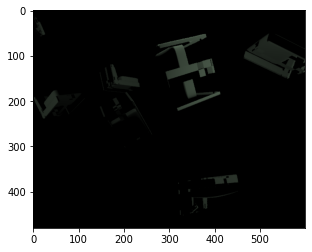

In [10]:
plt.imshow(images[1376])